In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
plt.rcParams["figure.autolayout"] = True
from scipy import stats

import pastas as ps
#ps.set_log_level("INFO")
ps.show_versions()

import logging, sys
logging.disable(sys.maxsize)

/Applications/anaconda3/envs/mude/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Pastas version: 1.9.0
Python version: 3.11.4
NumPy version: 1.24.3
Pandas version: 2.2.2
SciPy version: 1.10.1
Matplotlib version: 3.7.1
Numba version: 0.57.0


Definition of the extremes of calibration and validation periods according to the Groundwater Challenge instructions.  
- Calibration period: data used to fit the model.  
- Validation period: data used to test the model's predictive performance.

In [2]:
tmin_cal = "2002-03-01"
tmax_cal = "2016-12-31"
tmin_val = "2017-01-01"
tmax_val = "2022-05-31"

Importing the data.  
- `head`: Time series data of observed groundwater head levels, loaded from a CSV file.
- `stresses`: Time series data of various stressors, loaded from a CSV file.
Data is indexed by dates for time series analysis.  
This specific stresses dataset includes: 
- Precipitation data stored in the `prec` variable in [mm/day].
- River stage data stored in the `river` variable in [m].
- Evaporation data stored in the `evap` variable in [mm/day].  
Two different head datasets are provided, they are both imported, nonetheless, they are the exact same and cover the totality of the avaiable head observations.  
Using the complete head observations dataset, two subsets are created, one covering the calibration period (`head_cal`) and one covering the validation period (`head_val`).

In [3]:
head = pd.read_csv("data/heads.csv", index_col=0, parse_dates=True).squeeze()

stresses = pd.read_csv("data/input_data.csv", index_col=0, parse_dates=True).squeeze()
prec = stresses.iloc[:, 0].rename("prec").dropna()
river = stresses.iloc[:, 3].rename("riv").dropna()
evap = stresses.iloc[:, 4].rename("evap").dropna()

heads_full = head = pd.read_csv("data/heads_full.csv", index_col=0, 
                       parse_dates=True).squeeze()

head_cal = heads_full[(heads_full.index >= tmin_cal) & (heads_full.index <= tmax_cal)]
head_val = heads_full[(heads_full.index >= tmin_val) & (heads_full.index <= tmax_val)]

This plot provides a summary of the observed groundwater head levels and stressors over time.  
The visualization helps identify trends and patterns before model fitting, as well as getting a first idea of the order of magnitude of the head levels and stressors.

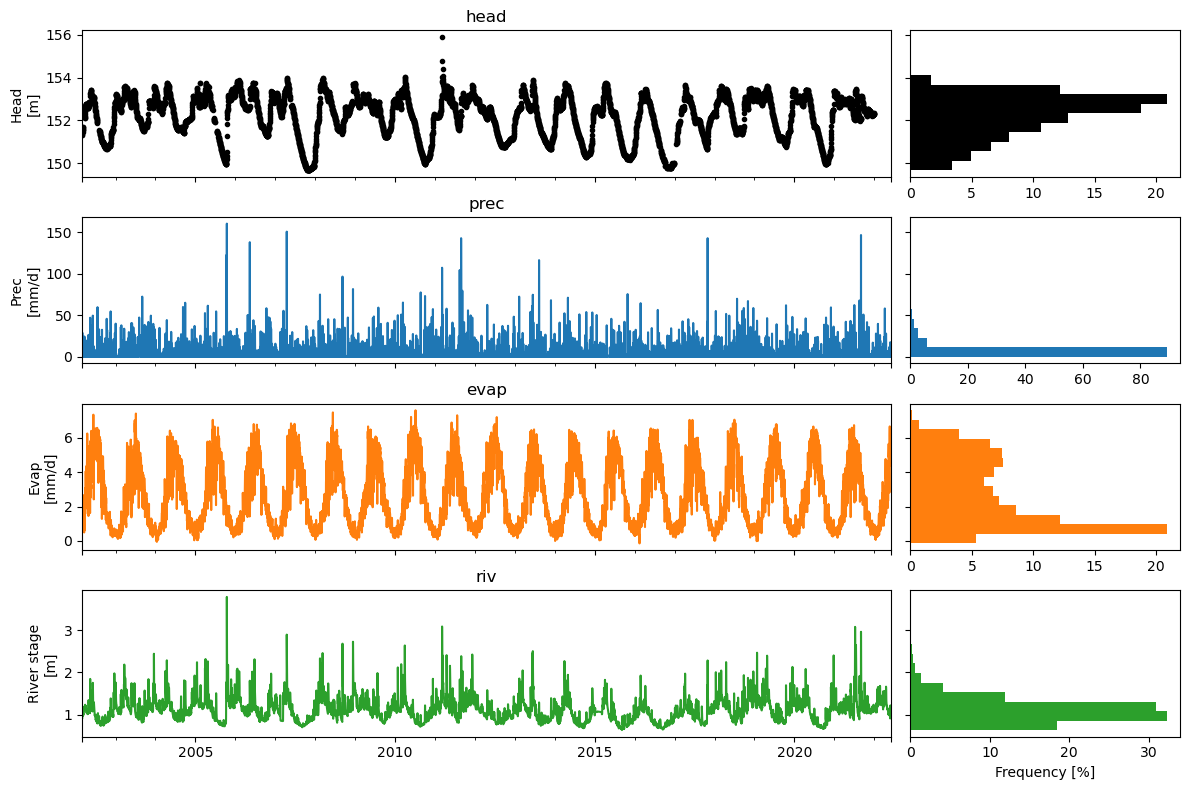

In [4]:
axes = ps.plots.series(
        head=head,
        stresses=[prec, evap, river],
        tmin=tmin_cal,
        tmax = tmax_val,
        labels=["Head\n[m]", "Prec\n[mm/d]", "Evap\n[mm/d]", "River stage\n[m]"],
        figsize = (12, 8))

Validation of imported datasets. This is done to make sure they meet the requirements to be used in PASTAS models.

In [5]:
ps.validate_oseries(head)
ps.validate_stress(prec)
ps.validate_stress(evap)
ps.validate_stress(river)

True

Set up PASTAS model.  

- The model is initialized using the groundwater head observations (`head`).
- A noisemodel is added to the model.
- The selected stress model, that performs better in representing the observations is the RechargeModel:
  - out of the availablee options, a Gamma response function was selected,
  - out of the available options, a Linear recharge model was selected, the other possible options (Berendrecht, FlexModel, Peterson) performed more poorly.  
This stressmodel was added to the pastas model.

The model was solved over the calibration period, the constant was not fitted as a parameter.
  
  


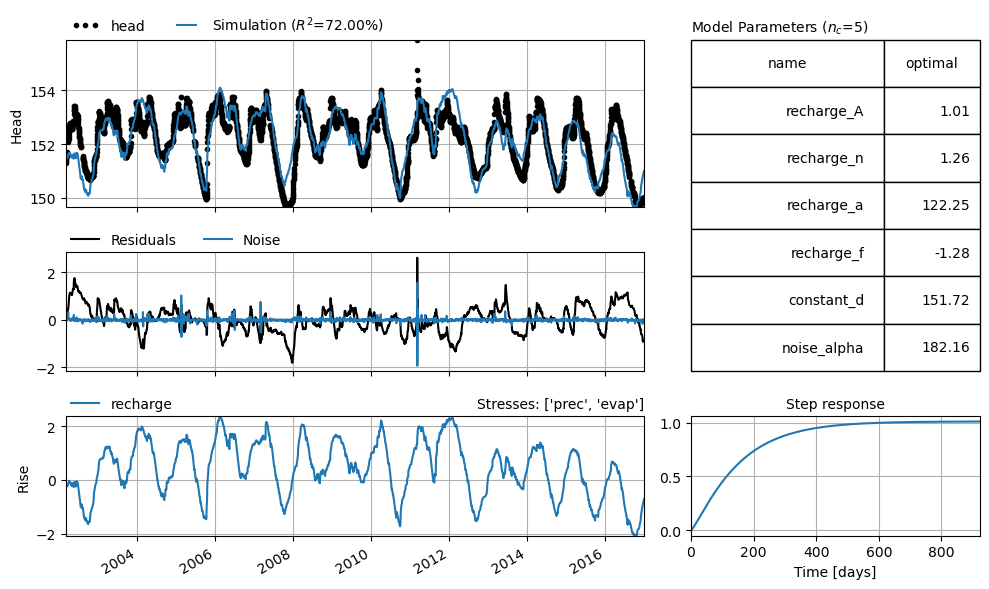

In [6]:
ml = ps.Model(head)
ml.add_noisemodel(ps.ArNoiseModel())

rch = ps.rch.Linear()
func = ps.Gamma()
sm = ps.RechargeModel(
    prec,
    evap,
    rfunc = func,
    recharge=rch,
    settings=("prec", "evap"),
)
ml.add_stressmodel(sm)

ml.solve(report=False, tmin=tmin_cal, tmax=tmax_cal, fit_constant = False)
axes = ml.plots.results(figsize=(10, 6))

The river stage data is available and is added as a stressmodel to the model. The river stage is modeled using a Gamma response function, the model is solved again for the calibration period.  
Adding the river stage increases the model performance which $R^2$ value goes from 72% to 88% (values rounded down).

Fit report head                    Fit Statistics
nfev    26                     EVP          88.24
nobs    5268                   R2            0.88
noise   True                   RMSE          0.35
tmin    2002-03-01 00:00:00    AICc     -30947.64
tmax    2016-12-31 00:00:00    BIC      -30895.11
freq    D                      Obj           7.38
warmup  3650 days 00:00:00     ___               
solver  LeastSquares           Interp.         No

Parameters (8 optimized)
                 optimal    initial   vary
recharge_A      0.298865   0.094664   True
recharge_n      2.106559   1.000000   True
recharge_a     65.030548  10.000000   True
recharge_f     -1.975230  -1.000000   True
waterlevel_A    2.559601   3.696743   True
waterlevel_n    0.863673   1.000000   True
waterlevel_a   17.201673  10.000000   True
constant_d    149.781624   0.000000  False
noise_alpha    92.810995   1.000000   True

Warnings! (2)
Response tmax for 'recharge' > than warmup period.
Response tmax for 'waterleve

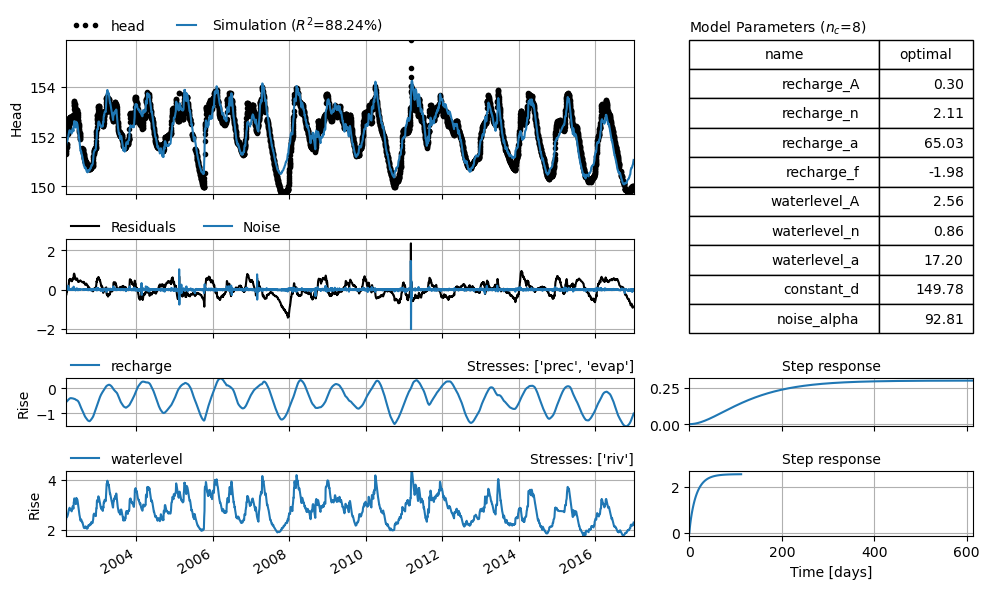

In [7]:
w = ps.StressModel(river, rfunc=ps.Gamma(), name="waterlevel", settings="waterlevel")
ml.add_stressmodel(w)

ml.solve(report=True, tmin=tmin_cal, tmax=tmax_cal, fit_constant = False)
axes = ml.plots.results(figsize=(10, 6))

A linear trend stressmodel is added, this is done with the intention of capturing long-term changes in groundwater head, the result does not show sensibly better fit. The stressmodel is therefore removed to limit the number of parameters, the process is left for completeness of the thought process.

Fit report head                    Fit Statistics
nfev    27                     EVP          88.31
nobs    5268                   R2            0.88
noise   True                   RMSE          0.35
tmin    2002-03-01 00:00:00    AICc     -30945.88
tmax    2016-12-31 00:00:00    BIC      -30886.79
freq    D                      Obj           7.38
warmup  3650 days 00:00:00     ___               
solver  LeastSquares           Interp.         No

Parameters (9 optimized)
                    optimal        initial   vary
recharge_A         0.306422       0.094664   True
recharge_n         2.083594       1.000000   True
recharge_a        66.740808      10.000000   True
recharge_f        -1.970739      -1.000000   True
waterlevel_A       2.559167       3.696743   True
waterlevel_n       0.863087       1.000000   True
waterlevel_a      17.240396      10.000000   True
trend_a            0.000016       0.000000   True
trend_tstart  733042.000000  733042.000000  False
trend_tend    735964.000

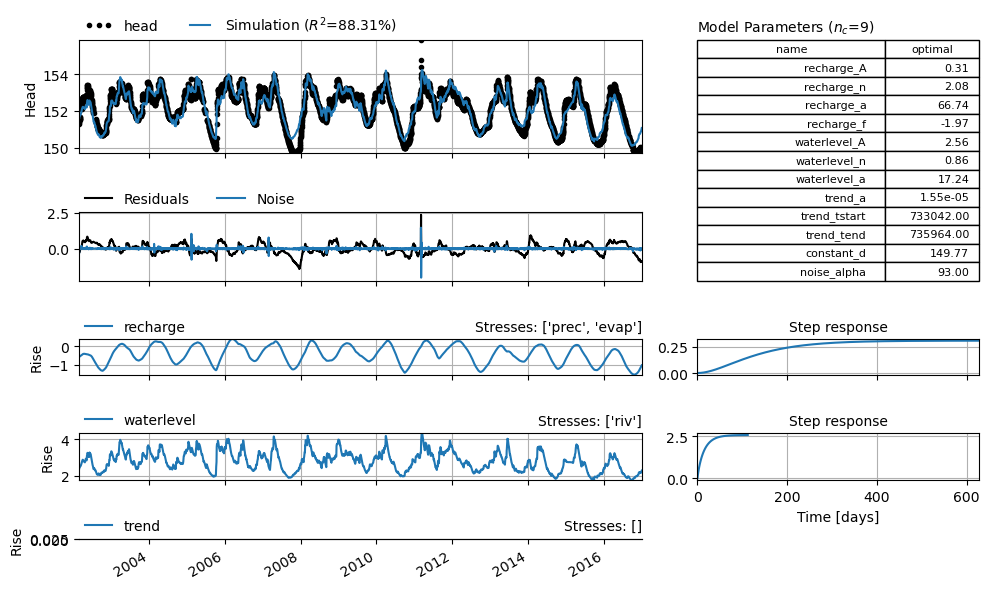

In [8]:
tm = ps.LinearTrend(start="2008-01-01", end="2016-01-01", name="trend")
ml.add_stressmodel(tm)

ml.solve(report=True, tmin=tmin_cal, tmax=tmax_cal, fit_constant = False)
axes = ml.plots.results(figsize=(10, 6))

In [9]:
ml.del_stressmodel("trend")

Based on the report from the last model solve, some of the parameters are manually initalized with values close to the optimal value obtained from the simulation. This is done with the hope that better optimal parameters will be estimated.  
The parameters that are manually initialized are the ones that show the highest difference between initial and optimal parameter in the previous simulation.  
Manually initializing the parameters does not make the fitting better, the code cell is still included for completeness of the thought process but could be removed since it does not increase the perforance.

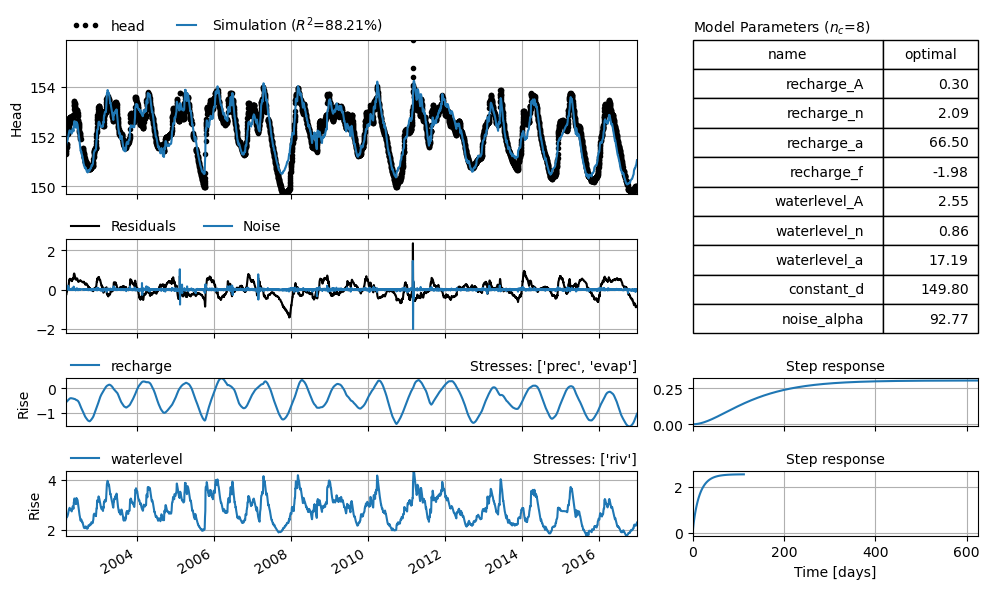

In [10]:
ml.set_parameter(name="recharge_A", initial=0.3, vary=True,
                 pmin=0, pmax=1)

ml.set_parameter(name="recharge_n", initial=2, vary=True,
                 pmin=0, pmax=10)

ml.set_parameter(name="recharge_a", initial=65, vary=True,
                 pmin=0, pmax=100)

ml.set_parameter(name="recharge_f", initial=-1.9, vary=True,
                 pmin=-5, pmax=5)



ml.solve(initial = False, report=False, tmin=tmin_cal, tmax=tmax_cal, fit_constant = False)
axes = ml.plots.results(figsize=(10, 6))

The head are simulated over the total period including the calibration and validation phases.

In [11]:
heads_sim = ml.simulate(tmin = tmin_cal, tmax = tmax_val)
sim_cal = ml.simulate(tmin = tmin_cal, tmax = tmax_cal)
sim_val = ml.simulate(tmin = tmin_val, tmax = tmax_val)

The 95% prediction interval for the model is computed and shown in a plot along with the simulated and observed head values over the validation period.

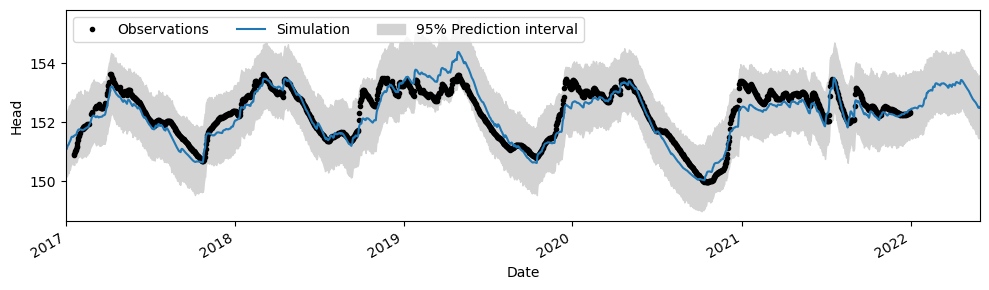

In [12]:
ci_val = ml.solver.prediction_interval(n=1000, alpha = 0.05, max_iter = 10000, tmin = tmin_val, tmax = tmax_val)
ci_cal = ml.solver.prediction_interval(n=1000, alpha = 0.05, max_iter = 10000, tmin = tmin_cal, tmax = tmax_cal)
ci_tot = ml.solver.prediction_interval(n=1000, alpha = 0.05, max_iter = 10000, tmin = tmin_cal, tmax = tmax_val)
ax = ml.plot(figsize=(10, 3), tmin = tmin_val, tmax = tmax_val)
ax.fill_between(ci_val.index, ci_val.iloc[:, 0], ci_val.iloc[:, 1], color="lightgray")
ax.legend(["Observations", "Simulation", "95% Prediction interval"], ncol=3, loc=2)

A comprehensive plot is provided including:
- scatter plot of observed head values over the total period (2002 - 2022).
- simulated head over the total period (2002 - 2022).
- 95% prediction interval over the validation period (2017 - 2022).

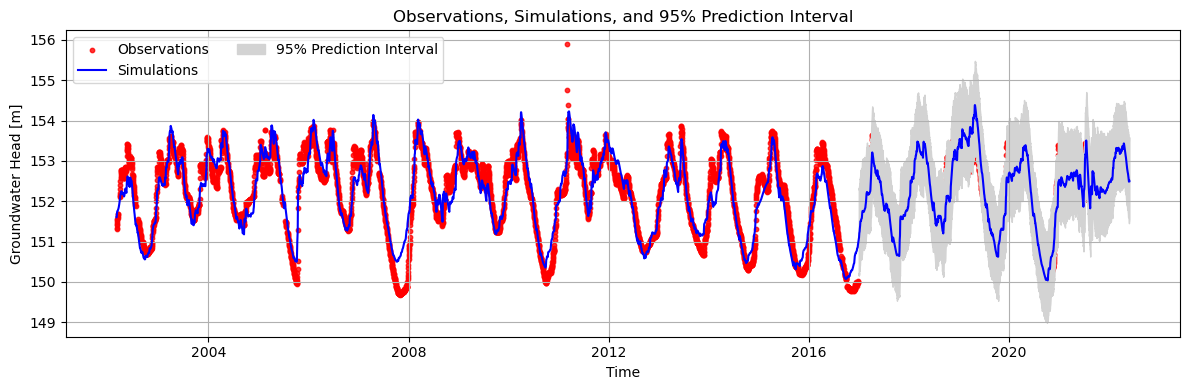

In [13]:
fig, ax = plt.subplots(figsize=(12, 4))


ax.scatter(
    heads_full.index,
    heads_full,
    label="Observations",
    color="red",
    s=10,  
    alpha=0.8,
)


ax.plot(
    heads_sim.index,
    heads_sim,
    label="Simulations",
    color="blue",
    linewidth=1.5,
)


ax.fill_between(
    ci_val.index,
    ci_val.iloc[:, 0],
    ci_val.iloc[:, 1],
    color="lightgray",
    label="95% Prediction Interval",
)


ax.set_title("Observations, Simulations, and 95% Prediction Interval")
ax.set_xlabel("Time")
ax.set_ylabel("Groundwater Head [m]")
ax.legend(loc="upper left", ncol=2)
ax.grid()

plt.show()

**Diagnostics checking**


A diagnostics check is performed. This is done to ensure that the model adequately describes the observed time series and the noisemodel is performing well.

The check is conducted to test the assumptions for white noise:
- No significant autocorrelation;
- Residuals are homoscedastic;
- Residuals follow a normal distribution.

The results of the diagnostics check show that all tests reject the null hypothesis, meaning that the data do not agree with the assumptions.

In [14]:
ml.stats.diagnostics(alpha=0.05)

p-value may not be accurate for N > 5000.

,Checks,Statistic,P-value,Reject H0 ($\alpha$=0.05)
Shapiroo,Normality,0.41,0.00,True
D'Agostino,Normality,6262.32,0.00,True
Runs test,Autocorr.,-25.08,0.00,True
Stoffer-Toloi,Autocorr.,408.53,0.00,True


**Reducing autocorrelation**

Autocorrelation is computed and displayed for time lags from 1 to 365 days. The autocorrelation plot shows that for the first 10-15 days the correlation between the observations is very close to one, it then drops significantly at around 20 days.

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

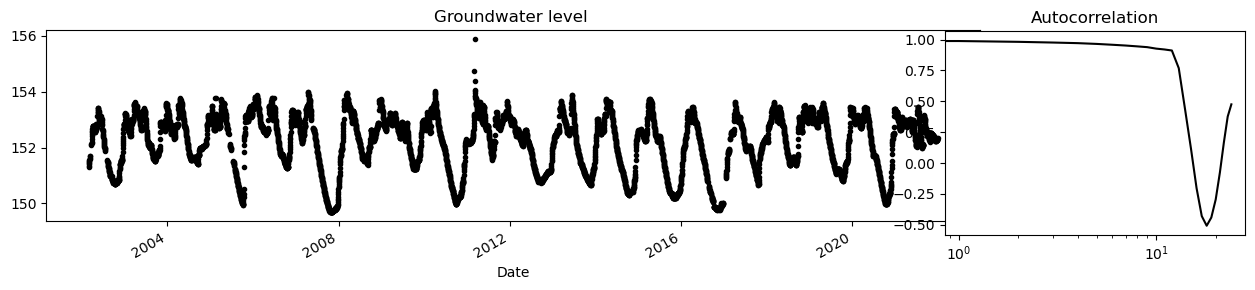

In [15]:
ax = head.plot(figsize=(10, 3), marker=".", linestyle=" ", color="k")
ax1 = plt.axes([0.95, 0.2, 0.3, 0.68])
acf = ps.stats.acf(
    head,
    lags=[
        1,
        2,
        3,
        4,
        5,
        6,
        7,
        8,
        9,
        10,
        12,
        13,
        14,
        30,
        61,
        90,
        120,
        150,
        180,
        210,
        240,
        270,
        300,
        330,
        365,
    ],
).values
ax1.semilogx(acf, color="k") 
ax.set_title("Groundwater level ")
ax1.set_title("Autocorrelation");

The code below performs an analysis to investigate the effect of varying temporal resolution. It creates and solves multiple models, each with a different level of temporal aggregation in the input time series.

1. **Initialization**:
   - `mls_ar`: Empty dictionary to store solved models.
   - `dts = 21`: Range of temporal resolution steps to test.

2. **Model iteration**:
   - The loop iterates over `dt`, creating **10 models** in total.
   - For each `dt`, the groundwater head time series (`head`) is downsampled using `head.iloc[::dt]`, resulting in progressively longer time intervals between observations.

3. **Model setup**:
   - A model is created for each `dt`.
   - A noise model (`ps.ArNoiseModel`) is added.
   - A recharge model (`ps.RechargeModel`) is configured as above.

5. **Model calibration**:
   - Each model is solved over the defined calibration period (`tmin_cal` to `tmax_cal`) to fit the parameters to the input data.

6. **Model storage**:
   - Solved models are stored in the dictionary `mls_ar`.
   
Output:
- **10 solved models** stored in `mls_ar`.
- Each model represents a different temporal resolution, with intervals between observations increasing according to the sequence of `dt` values: 1, 3, 5, ..., 19.

In [16]:
mls_ar = {}
dts = 21


rch = ps.rch.Linear()
rfunc = ps.Gamma()

for dt in range(1, dts, 2):
  
    ml_name = f"USA_{dt}"
    ml = ps.Model(head.iloc[::dt], name=ml_name)
    ml.add_noisemodel(ps.ArNoiseModel())

    sm = ps.RechargeModel(prec, evap, recharge=rch, rfunc=rfunc, name="rch")
    ml.add_stressmodel(sm)

    w = ps.StressModel(river, rfunc=ps.Gamma(), name="waterlevel", settings="waterlevel")
    ml.add_stressmodel(w)
    
    ml.solve(tmin=tmin_cal, tmax=tmax_cal, report=False)
    mls_ar[ml_name] = ml

The previously created groundwater models (`mls_ar`) are modyfied to analyze the impact of changing the noise model from autoregressive (AR) to autoregressive-moving-average (ARMA). The modified models are then calibrated and stored for comparison.

Outputs:
- Recalibrated models stored in `mls_arma`.
- Each model is identical to the one in `mls_ar`, except for the noise model type (ARMA instead of AR).

--> a decision can be made about the type of noise model to use.

In [17]:
mls_arma = {}

for ml_name, ml in mls_ar.items():
    ml = ml.copy(name=ml.name)

    ml.del_noisemodel()
    ml.add_noisemodel(ps.ArmaNoiseModel())

    ml.solve(tmin=tmin_cal, tmax=tmax_cal, report=False)
    mls_arma[ml_name] = ml

The performance of different noise models (AR and ARMA) is evaluated by computing the Durbin-Watson (DW) statistic. The results are plotted to compare the two noise models at varying temporal resolutions (`dt`).

1. **Data preparation**
- Two empty DataFrames (`data` and `data2`) are initialized to store the DW statistic for each temporal resolution (`dt`) and noise model.

2. **Compute DW statistic for AR noise models**
- Loop through all models in `mls_ar` (models with AR noise)

3. **DW statistic for ARMA noise models**
- Loop through all models in `mls_arma` (models with ARMA noise)

4. **Results**
- Two subplots (`ax1` and `ax2`) for AR and ARMA noise models are created, respectively:
  - **AR(1) Noise Model**:
    - Plot of DW statistics from `data` for each `dt`.
    - Dashed line at `DW = 2.0`, indicating no autocorrelation.
  - **ARMA(1,1) Noise Model**:
    - Plot pf DW statistics from `data2` for each `dt`.
    - Dashed line at `DW = 2.0`, indicating no autocorrelation.


The Durbin-Watson statistic is used as the metric:
- **DW = 2.0**: Indicates no autocorrelation.
- **DW < 2.0**: Indicates positive autocorrelation.

Outputs:
- **Two plots** comparing DW statistics for AR(1) and ARMA(1,1) noise models.
- Visual comparison of how the two noise models handle residual autocorrelation across varying temporal resolutions.

In this case, a model with a AR(1) noisemodel, with a 15 days time lag shows the lowest autocorrelation.

invalid value encountered in divideinvalid value encountered in divideinvalid value encountered in divideinvalid value encountered in divide

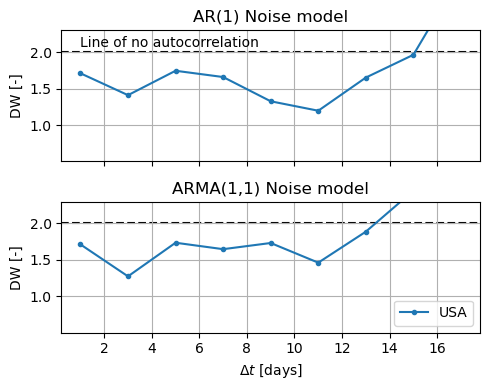

In [18]:
data = pd.DataFrame(index=range(dt, 1), columns=["USA"])

for ml in mls_ar.values():
    if "USA" in ml.name:
        name, i = ml.name.split("_")
        n = ml.noise(tmin=tmin_cal, tmax=tmax_val).asfreq(f"{i}D").fillna(0.0)
        data.loc[int(i), name] = ps.stats.durbin_watson(n)[0]

data2 = pd.DataFrame(index=range(dt, 1), columns=["USA"])

for ml in mls_arma.values():
    if "USA" in ml.name:
        name, i = ml.name.split("_")
        n = ml.noise(tmin=tmin_cal, tmax=tmax_val).asfreq(f"{i}D").fillna(0.0)
        data2.loc[int(i), name] = ps.stats.durbin_watson(n)[0]


fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True, figsize=(5, 4), sharey=True)


data.plot(ax=ax1, marker=".", legend=False)
ax1.set_ylabel("DW [-]")
ax1.axhline(2.0, c="k", linestyle="--", zorder=-1)
ax1.text(1, 2.07, "Line of no autocorrelation")
ax1.grid()
ax1.set_title("AR(1) Noise model")


data2.plot(ax=ax2, marker=".", legend=False)
ax2.set_ylabel("DW [-]")
ax2.set_yticks([1, 1.5, 2.0])
ax2.axhline(2.0, c="k", linestyle="--", zorder=-10)
ax2.set_ylim(0.5, 2.3)
ax2.grid()
ax2.legend(ncol=3, loc=4)
ax2.set_xlabel("$\\Delta t$ [days]")
ax2.set_title("ARMA(1,1) Noise model")
plt.tight_layout()

The data is split into segments starting at different offsets (`start`), multiple models are created and solved, storing the results. The model is solved with a 15 days time lag, an AR(1) noisemodel is added according to the plot above.

1. **Initialization**:
- `mls`: An empty dictionary to store solved models.
- `dt = 15`: Defines the temporal resolution or step size for input data segmentation, chosen based on the previous plots.
- Recharge and response functions:
  - `rfunc`: `Exponential()` for modeling the aquifer response.
  - `rch`: `FlexModel()` for modeling nonlinear recharge dynamics.

2. **Models creation**:
- Loops over starting offsets (`start`) from `0` to `dt - 1` (15 iterations):
  - Creates distinct models by slicing the `head` time series with an offset:
    ```python
    head.iloc[start::dt]
    ```
    This creates sub-series where each model begins at a different temporal offset and uses every `dt`-th observation.

3. **Model configuration**:
- A recharge model (`ps.RechargeModel`) is added to simulate groundwater recharge using the same settings as above.
- Parameters are initialized as above.



5. **Noise model**:
- An AR noise model (`ps.ArNoiseModel()`) is added.

6. **Model calibration**:
- Each model is solved over the defined calibration period (`tmin_cal` to `tmax_cal`).



Output:
- **15 calibrated models**, each representing a different temporal offset.
  - X-axis: Observation indices adjusted by `start`.
  - Y-axis: Observed and simulated groundwater head.
- Models are stored in the `mls` dictionary, with keys like `USA_1`, `USA_2`, etc., corresponding to the starting offsets.


In [19]:
mls_with = {}
dt = 15


rch = ps.rch.Linear()
rfunc = ps.Gamma()

for start in range(0, dt, 1):
    ml_name = f"USA_{start + 1}"
    ml = ps.Model(head.iloc[start::dt], name=ml_name)
    ml.add_noisemodel(ps.ArNoiseModel())

    sm = ps.RechargeModel(prec, evap, recharge=rch, rfunc=rfunc, name="rch")
    ml.add_stressmodel(sm)

    w = ps.StressModel(river, rfunc=ps.Gamma(), name="waterlevel", settings="waterlevel")
    ml.add_stressmodel(w)

    
    ml.add_noisemodel(ps.ArmaNoiseModel())
    ml.solve(tmin=tmin_cal, tmax=tmax_cal, report=False)

    mls_with[ml_name] = ml

In [20]:
mls_without = {}
dt = 15


rch = ps.rch.Linear()
rfunc = ps.Gamma()

for start in range(0, dt, 1):
    ml_name = f"USA_{start + 1}"
    ml = ps.Model(head.iloc[start::dt], name=ml_name)
    ml.add_noisemodel(ps.ArNoiseModel())

    sm = ps.RechargeModel(prec, evap, recharge=rch, rfunc=rfunc, name="rch")
    ml.add_stressmodel(sm)

    w = ps.StressModel(river, rfunc=ps.Gamma(), name="waterlevel", settings="waterlevel")
    ml.add_stressmodel(w)

    ml.solve(tmin=tmin_cal, tmax=tmax_cal, report=False)

    mls_without[ml_name] = ml

In this code cell the parameter estimates and uncertainties for models with and without noisemodels are organized in `df_with` and `df_without`.

In [21]:
data = {}

name = "USA"
ml = mls_with["{}_1".format(name)]
p = ml.parameters
mi = pd.MultiIndex.from_product([p.index[p.vary].to_list(), ["opt", "std"]])
data[name] = pd.DataFrame(data=np.nan, index=range(dt, 1), columns=mi, dtype=float)

for ml in mls_with.values():
    if "USA" in ml.name:
        name, i = ml.name.split("_")
        df = data[name]
        for par in ml.parameters.index[ml.parameters.vary]:
            df.loc[int(i), (par, "opt")] = ml.parameters.loc[par, "optimal"]
            df.loc[int(i), (par, "std")] = ml.parameters.loc[par, "stderr"]
        
df_with = pd.concat(data, axis=1)
df_with

USA                                                             \
       rch_A               rch_n                    rch_a                 
         opt       std       opt           std        opt           std   
1   0.375291  0.088770  1.870592  3.388229e-01  83.172703  2.887738e+01   
2   0.366108  0.088719  1.882457  3.519289e-01  82.712995  2.947805e+01   
3   0.359448  0.086004  1.964124  3.817111e-01  75.567208  2.606102e+01   
4   0.349134  0.084662  1.998821  4.011537e-01  72.148805  2.490879e+01   
5   0.327556  0.086806  2.057350  4.593424e-01  68.311715  2.518297e+01   
6   0.328235  0.085858  2.055564  4.604260e-01  68.445892  2.534652e+01   
7   0.354217  0.082210  2.063016  4.224184e-01  67.691147  2.278528e+01   
8   0.334667  0.082160  2.078546  4.498172e-01  67.563258  2.399956e+01   
9   0.336390  0.079038  2.258649  5.323679e-01  58.019263  2.048027e+01   
10  0.006955  0.001273  0.011635  1.038827e-14   0.010016  1.386575e-14   
11  0.274709  0.082782  2.272671  5.811710e-01  60.818945  2.417028e+01   
12  0.287307  0.079913  2.328561  5.583878e-01  58.305822  2.126716e+01   
13  0.298807  0.079929  2.207916  5.048779e-01  62.067562  2.234794e+01   
14  0.316671  0.077725  2.237600  4.923856e-01  60.563292  2.057546e+01   
15  0.333142  0.082294  2.096818  4.179113e-01  67.183936  2.214110e+01   

                                                                          \
           rch_f           waterlevel_A           waterlevel_n             
             opt       std          opt       std          opt       std   
1  -1.804198e+00  0.422272     2.729841  0.281106     0.867832  0.068472   
2  -1.857503e+00  0.444418     2.722325  0.281404     0.887900  0.074350   
3  -1.799729e+00  0.406323     2.680282  0.274147     0.911839  0.076509   
4  -1.785448e+00  0.395126     2.694856  0.283181     0.891731  0.076920   
5  -1.807937e+00  0.418714     2.759451  0.315521     0.824300  0.074633   
6  -1.834603e+00  0.422223     2.739863  0.304677     0.828832  0.078164   
7  -1.770157e+00  0.366504     2.561018  0.265996     0.931740  0.087648   
8  -1.834134e+00  0.404585     2.633010  0.281242     0.892620  0.087882   
9  -1.821257e+00  0.367902     2.300370  0.260490     1.020251  0.133282   
10 -8.489645e-30  2.022825     5.136066  0.364864     0.679208  0.043363   
11 -1.999398e+00  0.511036     2.842860  0.326424     0.793117  0.063859   
12 -1.895838e+00  0.438036     2.746556  0.298881     0.805013  0.064912   
13 -1.911622e+00  0.441078     2.673779  0.277037     0.810062  0.062295   
14 -1.791603e+00  0.382922     2.651665  0.252989     0.876488  0.060984   
15 -1.825519e+00  0.377493     2.631882  0.226903     0.934339  0.080041   

                                                                         \
   waterlevel_a             constant_d           noise_alpha              
            opt        std         opt       std         opt        std   
1     15.781775   3.418056  149.499813  0.492990   64.405082  13.476169   
2     15.646966   3.410577  149.553049  0.503290   65.286214  13.821754   
3     14.608748   3.052003  149.540152  0.481566   63.095602  13.338059   
4     15.094472   3.306689  149.505728  0.473066   58.628102  12.156410   
5     17.201013   4.312353  149.440604  0.492448   57.410701  12.412507   
6     16.282893   4.023099  149.491439  0.492830   57.621941  12.620871   
7     13.016382   2.857835  149.653391  0.464993   57.584784  12.269664   
8     14.397144   3.467693  149.615046  0.478324   55.343102  11.650547   
9     10.199789   2.682959  149.972758  0.481806   54.426310   9.840917   
10    52.002137  10.116463  146.489456  0.389424   61.160780  14.348291   
11    18.668325   4.594726  149.444192  0.514846   53.513279  10.989291   
12    17.092588   3.916951  149.486679  0.480075   58.469997  12.082921   
13    16.010961   3.423937  149.580516  0.472806   60.887947  12.896033   
14    13.390613   2.480135  149.531756  0.448347   59.962952  12.622155   
15    12.93208

In [22]:
data = {}

name = "USA"
ml = mls_without["{}_1".format(name)]
p = ml.parameters
mi = pd.MultiIndex.from_product([p.index[p.vary].to_list(), ["opt", "std"]])
data[name] = pd.DataFrame(data=np.nan, index=range(dt, 1), columns=mi, dtype=float)

for ml in mls_without.values():
    if "USA" in ml.name:
        name, i = ml.name.split("_")
        df = data[name]
        for par in ml.parameters.index[ml.parameters.vary]:
            df.loc[int(i), (par, "opt")] = ml.parameters.loc[par, "optimal"]
            df.loc[int(i), (par, "std")] = ml.parameters.loc[par, "stderr"]
        
df_without = pd.concat(data, axis=1)
df_without

USA                                                             \
       rch_A               rch_n                    rch_a                 
         opt       std       opt           std        opt           std   
1   0.363646  0.094874  1.905463  3.535021e-01  79.824574  2.753988e+01   
2   0.361176  0.094033  1.933939  3.617574e-01  77.531268  2.640370e+01   
3   0.357689  0.092837  1.958728  3.751146e-01  75.333486  2.569695e+01   
4   0.342071  0.089804  2.014955  4.010162e-01  70.645456  2.400858e+01   
5   0.312661  0.089620  2.050563  4.660940e-01  68.522581  2.587129e+01   
6   0.325187  0.089078  2.043704  4.530188e-01  68.627594  2.525820e+01   
7   0.361034  0.088165  2.042550  4.014110e-01  68.109557  2.222464e+01   
8   0.340670  0.087370  2.083474  4.342943e-01  66.533273  2.267990e+01   
9   0.329187  0.079492  2.255450  5.362096e-01  57.489849  2.036352e+01   
10  0.007002  0.001262  0.679506  5.439634e-15   0.049919  1.870509e-14   
11  0.288909  0.088465  2.198680  5.195176e-01  62.811691  2.356081e+01   
12  0.294381  0.086394  2.273221  5.133708e-01  59.587854  2.081435e+01   
13  0.311343  0.086433  2.203064  4.749173e-01  62.338207  2.126535e+01   
14  0.323998  0.084140  2.246630  4.737343e-01  60.223259  1.964478e+01   
15  0.346885  0.088598  2.056236  3.992521e-01  69.480898  2.275610e+01   

                                                                          \
           rch_f           waterlevel_A           waterlevel_n             
             opt       std          opt       std          opt       std   
1  -1.815215e+00  0.417641     2.703507  0.250065     0.857776  0.078206   
2  -1.790212e+00  0.405767     2.690799  0.249617     0.883737  0.084062   
3  -1.801769e+00  0.405402     2.652595  0.247583     0.909854  0.083628   
4  -1.800106e+00  0.398858     2.667579  0.255602     0.890308  0.083379   
5  -1.893284e+00  0.462342     2.760046  0.297602     0.826027  0.077014   
6  -1.839492e+00  0.430229     2.730894  0.290538     0.826430  0.079739   
7  -1.731347e+00  0.355563     2.539975  0.247183     0.927416  0.091561   
8  -1.767500e+00  0.379322     2.614147  0.258032     0.901083  0.092885   
9  -1.841703e+00  0.382172     2.282236  0.257827     1.028238  0.135740   
10 -5.706462e-23  2.000273     5.150748  0.371625     0.680023  0.043414   
11 -1.919966e+00  0.474012     2.793025  0.294997     0.788743  0.070527   
12 -1.832025e+00  0.419118     2.753911  0.269276     0.805880  0.074183   
13 -1.818449e+00  0.404508     2.680882  0.249398     0.823381  0.072131   
14 -1.741249e+00  0.364407     2.652647  0.230840     0.883246  0.069316   
15 -1.775794e+00  0.381833     2.619075  0.225264     0.936706  0.080644   

                                                                         
   waterlevel_a             constant_d           noise_alpha             
            opt        std         opt       std         opt        std  
1     15.498063   3.381827  149.540701  0.473934   98.383429  21.735802  
2     15.115453   3.254936  149.526380  0.465298   98.171888  21.737051  
3     14.291866   2.942297  149.577719  0.467895   91.403160  19.606303  
4     14.731227   3.150248  149.548372  0.456578   84.841966  17.566445  
5     17.114994   4.201169  149.501704  0.493091   69.482123  13.285967  
6     16.278141   3.962296  149.504740  0.485189   67.566135  12.783205  
7     12.840569   2.781654  149.646843  0.448356   76.989907  15.430670  
8     13.862564   3.220631  149.582360  0.453459   75.694249  15.051590  
9     10.026084   2.640431  150.007199  0.482977   52.565220   9.272166  
10    52.370060  10.301614  146.470148  0.399402   58.290620  10.400489  
11    18.072994   4.401429  149.459571  0.481784   78.802865  15.883370  
12    16.637565   3.751504  149.439966  0.447470   88.861467  18.867864  
13    15.412685   3.207918  149.522232  0.442926   89.896019  19.218718  
14    13.114216   2.397330  149.498221  0.426075   87.040301  18.295830  
15    12.841817   2.412770  149

### Parameter Variability Across Models

This code plots error bars to compare parameter variability across models with and without a noise model.

- Extracts models & parameters from `df_with`.
- Creates subplots for each parameter.
- Loops through parameters, checking for `opt` (optimized values) and `std` (standard deviation).
- Plots error bars for both datasets (`df_with` and `df_without`), showing uncertainty.
- Formats plots with labels, legends, grid lines, and a shared x-axis.
- Skips missing parameters and prints a message.

The result visualizes how the noise model affects different parameters as well as the influence of starting the simulation from different timesteps.

Skipping noise_beta, columns not found in df.


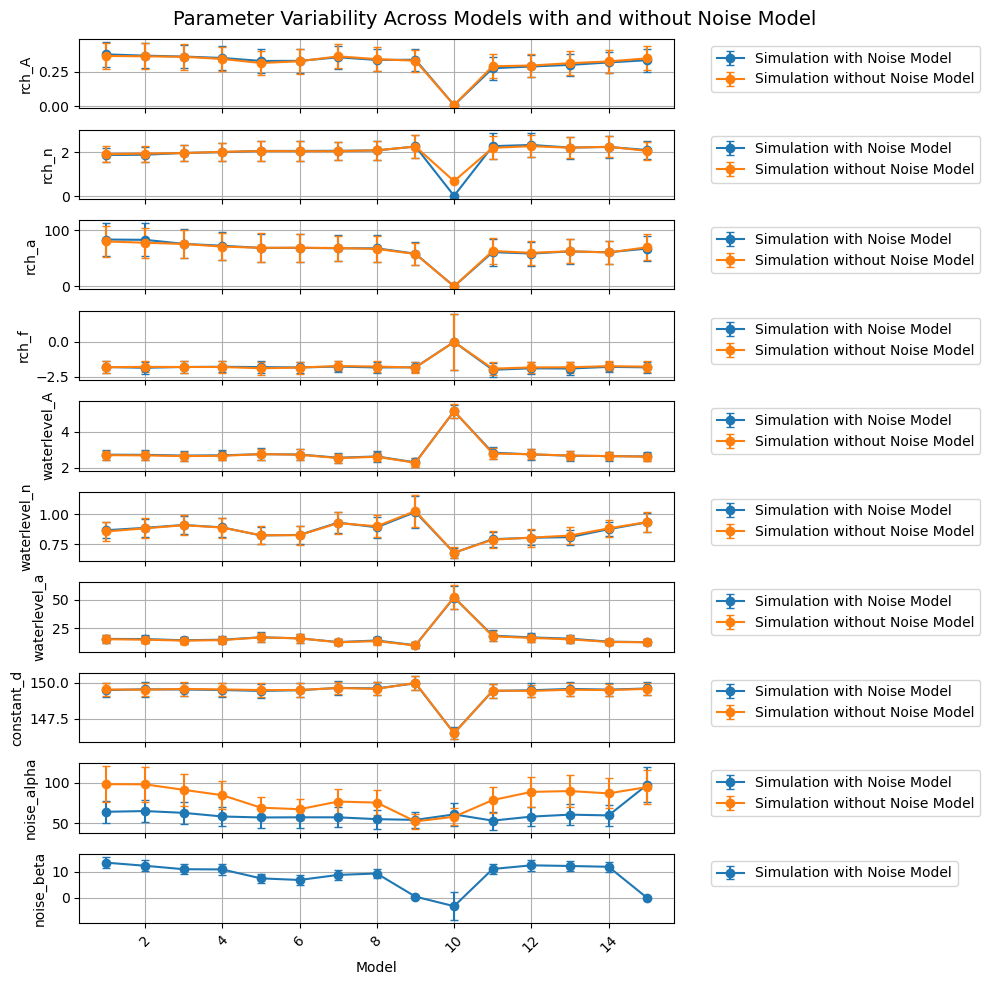

In [23]:
models = df_with.index
std_avg_with = []
std_avg_without = []
parameters = df_with["USA"].columns.get_level_values(0).unique()

fig, axes = plt.subplots(len(parameters), 1, figsize=(10, 10), sharex=True)

for i, param in enumerate(parameters):
    if ("USA", param, "opt") in df_with.columns and ("USA", param, "std") in df_with.columns:
        opt_with = df_with[("USA", param, "opt")]
        std_with = df_with[("USA", param, "std")]
        std_avg_with.append(std_with.mean())

        axes[i].errorbar(df_with.index, opt_with, yerr=std_with, fmt="-o", capsize=3, label = "Simulation with Noise Model")
        axes[i].set_ylabel(param)
        axes[i].grid(True)
        axes[i].legend(loc="upper left", bbox_to_anchor=(1.05, 1), fontsize=10, frameon=True)
    else:
        print(f"Skipping {param}, columns not found in df.")
        
    if ("USA", param, "opt") in df_without.columns and ("USA", param, "std") in df_without.columns:
        opt_without = df_without[("USA", param, "opt")]
        std_without = df_without[("USA", param, "std")]
        std_avg_without.append(std_with.mean())

        axes[i].errorbar(df_without.index, opt_without, yerr=std_without, fmt="-o", capsize=3, label = "Simulation without Noise Model")
        axes[i].set_ylabel(param)
        axes[i].grid(True)
        axes[i].legend(loc="upper left", bbox_to_anchor=(1.05, 1), fontsize=10, frameon=True)
    else:
        print(f"Skipping {param}, columns not found in df.")

axes[-1].set_xlabel("Model")
fig.suptitle("Parameter Variability Across Models with and without Noise Model", fontsize=14)


plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The uncertainty behind the parameters is quantified by computing the standard deviation for both models with and without the noisemodel. Please note that the parameters uncertainty is normalized using the absolute value of the parameter itself.

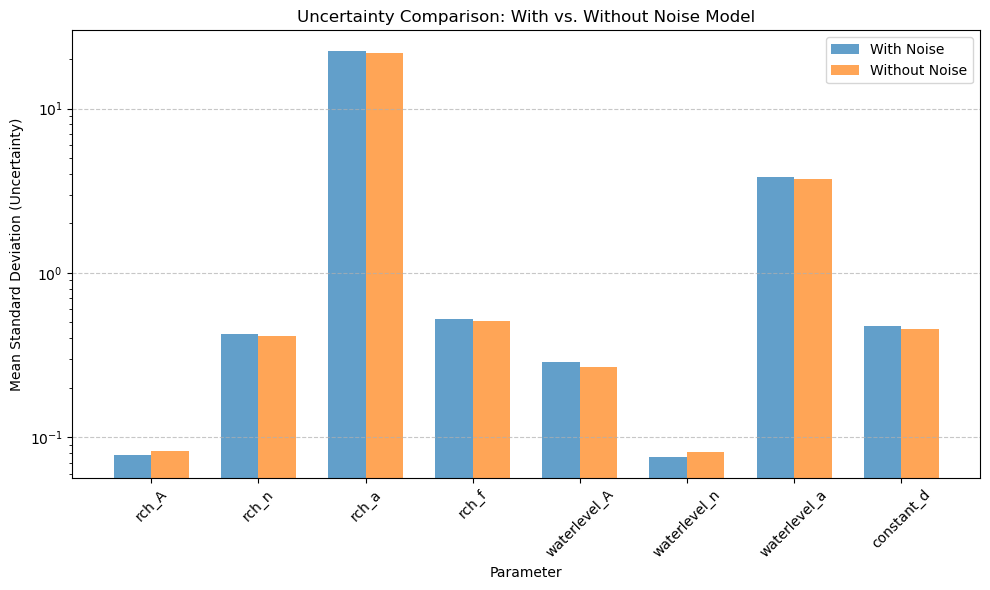

In [24]:
std_avg_with = [df_with[("USA", param, "std")].mean() for param in parameters[:-2]]
std_avg_without = [df_without[("USA", param, "std")].mean() for param in parameters[:-2]]


uncertainty_df = pd.DataFrame({
    "Parameter": parameters[:-2],
    "With Noise": std_avg_with,
    "Without Noise": std_avg_without
})


fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(parameters[:-2]))

bars1 = ax.bar(index, std_avg_with, bar_width, label='With Noise', alpha=0.7)
bars2 = ax.bar(index + bar_width, std_avg_without, bar_width, label='Without Noise', alpha=0.7)

ax.set_xlabel('Parameter')
ax.set_ylabel('Mean Standard Deviation (Uncertainty)')
ax.set_title('Uncertainty Comparison: With vs. Without Noise Model')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(parameters[:-2], rotation=45)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_yscale("log")

plt.tight_layout()
plt.show()

The diagnostics check is conducted again and the autocorrelation problem seems to be resolved for all the models.

In [25]:
for name, model in mls_with.items():
    print(f"Model name: {name}")
    print(model.stats.diagnostics(alpha=0.05))
    

Model name: USA_1
                  Checks Statistic P-value  Reject H0 ($\alpha$=0.05)
Shapiroo       Normality      0.98    0.00                       True
D'Agostino     Normality     27.51    0.00                       True
Runs test      Autocorr.     -1.71    0.09                      False
Stoffer-Toloi  Autocorr.      9.23    0.76                      False
Model name: USA_2
                  Checks Statistic P-value  Reject H0 ($\alpha$=0.05)
Shapiroo       Normality      0.97    0.00                       True
D'Agostino     Normality     27.49    0.00                       True
Runs test      Autocorr.     -1.92    0.05                      False
Stoffer-Toloi  Autocorr.     10.15    0.68                      False
Model name: USA_3
                  Checks Statistic P-value  Reject H0 ($\alpha$=0.05)
Shapiroo       Normality      0.97    0.00                       True
D'Agostino     Normality     28.88    0.00                       True
Runs test      Autocorr.     -1.28  

In [26]:
model_with = mls_with["USA_1"]
model_without = mls_without["USA_1"]

Autocorrelation is visually inspected and a stoffer-toloi check is computed, both showing positive results, there is no significant autocorrelation.

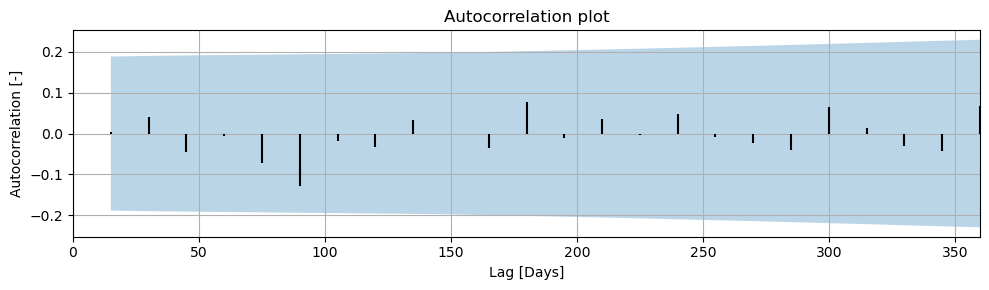

In [27]:
noise = model_with.noise()
ax = ps.plots.acf(noise, acf_options=dict(bin_width=0.5), figsize=(10, 3), alpha=0.01)

In [28]:
stat, p = ps.stats.stoffer_toloi(noise, lags=15)

if p > 0.5:
    print(
        "Failed to reject the Null-hypothesis, no significant autocorrelation. p =",
        p.round(2),
    )
else:
    print("Reject the Null-hypothesis. p =", p.round(2))

Failed to reject the Null-hypothesis, no significant autocorrelation. p = 0.87


**Normality Checking**

Normality is checked visually by looking at the probability plot and at the histogram of the residuals with a normal distribution fit to it.

Most points on the probability plot lie close to the line of perfect normality, deviations are present at upper tail, suggesting presence of non-normality in the residuals.

The histogram appears to be slightly skewed to the left.

Normality cannot be confirmed, as the null-hypothesis of the normality check is rejected.

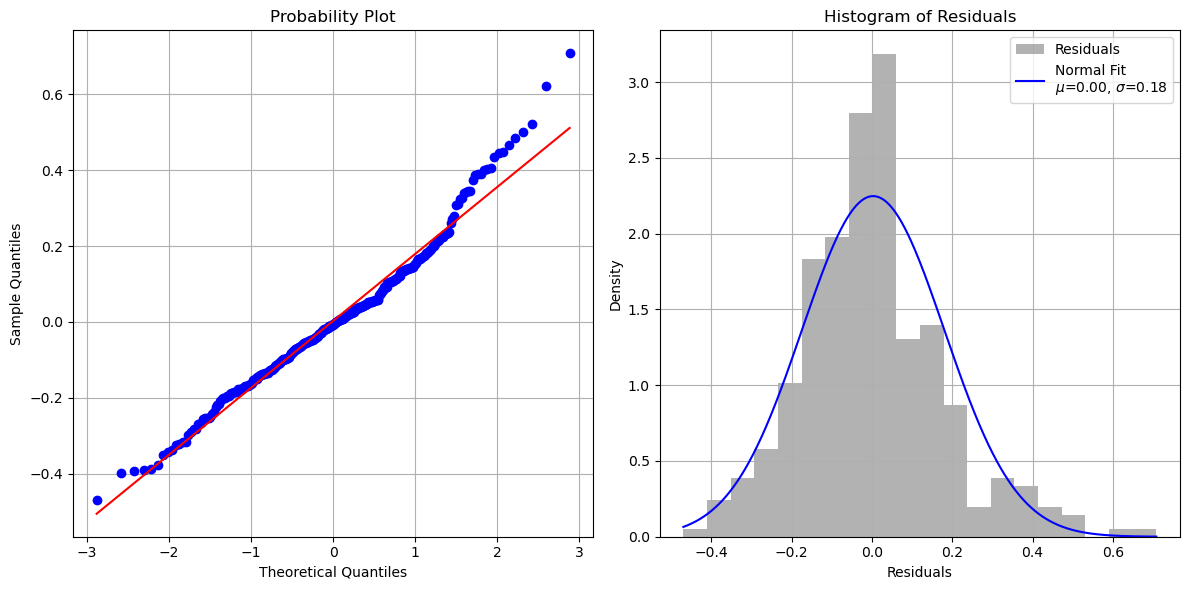

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))


stats.probplot(noise, dist="norm", plot=axes[0])
axes[0].set_title("Probability Plot")
axes[0].set_xlabel("Theoretical Quantiles")
axes[0].set_ylabel("Sample Quantiles")
axes[0].grid()

axes[1].hist(noise, bins=20, density=True, alpha=0.6, color="gray", label="Residuals")


mu, std = stats.norm.fit(noise)
x = np.linspace(min(noise), max(noise), 1000)
pdf = stats.norm.pdf(x, loc=mu, scale=std)
axes[1].plot(x, pdf, color="blue", label=f"Normal Fit\n$\mu$={mu:.2f}, $\sigma$={std:.2f}")
axes[1].set_title("Histogram of Residuals")
axes[1].set_xlabel("Residuals")
axes[1].set_ylabel("Density")
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

In [30]:
stat, p = stats.normaltest(noise)

if p > 0.5:
    print(
        "Failed to reject the Null-hypothesis, residuals may come from Normal distribution. p =",
        p.round(2),
    )
else:
    print("Reject the Null-hypothesis. p =", p.round(2))

Reject the Null-hypothesis. p = 0.0


**Homoscedasticity Checking**

Homoscedasticity is visually inspected, the goal is to check wheter values of the residuals are independent of the observed groundwater levels.

The spread of residuals seems consistent across the range of simulated groundwater levels, with no clear pattern of increasing or decreasing variance. The residuals appear randomly distributed around zero, without any systematic trend or curvature. 
These observations suggests that the assumption of homoscedasticity might be valid.

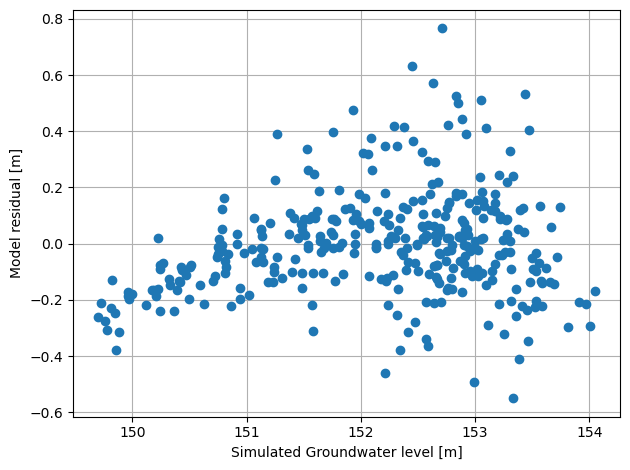

In [31]:
plt.plot(model.observations(), model.noise(), marker="o", linestyle=" ")
plt.xlabel("Simulated Groundwater level [m]")
plt.ylabel("Model residual [m]")
plt.grid()

**Performance Assessment**

After the diagnostics checking and the reduction of autocorrelation the performance of the model is assessed using two different metrics, as requested from the groundwater challenge.  
The metrics applied are:
- Nash-Sutcliffe Efficiency (NSE) over the two periods;
- Mean Absolute Error (MAE) over heads value below the 0.2 quantile and above the 0.8 quantile for both calibration and validation periods.  

The results show better fit in the calibration period, with better representation of high end values.

In [32]:
sim_cal_with = model_with.simulate(tmin = tmin_cal, tmax = tmax_cal)
sim_val_with = model_with.simulate(tmin = tmin_val, tmax = tmax_val)
heads_sim_with = model_with.simulate(tmin = tmin_cal, tmax = tmax_val)

nse_cal_with = ps.stats.metrics.nse(obs = head_cal, sim = sim_cal_with)
nse_val_with = ps.stats.metrics.nse(obs = head_val, sim = sim_val_with)

q02_obs_cal_with = head_cal[head_cal <= head_cal.quantile(0.2)]
q02_sim_cal_with = sim_cal_with.loc[q02_obs_cal_with.index]

q02_obs_val_with = head_val[head_val <= head_val.quantile(0.2)]
q02_sim_val_with = sim_val_with.loc[q02_obs_val_with.index]

q08_obs_cal_with = head_cal[head_cal <= head_cal.quantile(0.8)]
q08_sim_cal_with = sim_cal_with.loc[q08_obs_cal_with.index]

q08_obs_val_with = head_val[head_val <= head_val.quantile(0.8)]
q08_sim_val_with = sim_val_with.loc[q08_obs_val_with.index]

mae_cal02_with = ps.stats.metrics.mae(obs = q02_obs_cal_with, sim = q02_sim_cal_with)
mae_cal08_with = ps.stats.metrics.mae(obs = q08_obs_cal_with, sim = q08_sim_cal_with)

mae_val02_with = ps.stats.metrics.mae(obs = q02_obs_val_with, sim = q02_sim_val_with)
mae_val08_with = ps.stats.metrics.mae(obs = q08_obs_val_with, sim = q08_sim_val_with)


print(f"Results of fit test for model with noisemodel:\n"
      f"  - NSE over calibration period: {nse_cal_with:.4f}.\n"
      f"  - MAE_02 over calibration period: {mae_cal02_with:.4f}.\n"
      f"  - MAE_08 over calibration period: {mae_cal08_with:.4f}.\n"
      "\n"
      f"  - NSE over validation period: {nse_val_with:.4f}.\n"
      f"  - MAE_02 over validation period: {mae_val02_with:.4f}.\n"
      f"  - MAE_08 over validation period: {mae_val08_with:.4f}.\n")

Results of fit test for model with noisemodel:
  - NSE over calibration period: 0.8776.
  - MAE_02 over calibration period: 0.3334.
  - MAE_08 over calibration period: 0.2850.

  - NSE over validation period: 0.7854.
  - MAE_02 over validation period: 0.2692.
  - MAE_08 over validation period: 0.3121.



In [33]:
sim_cal_without = model_without.simulate(tmin = tmin_cal, tmax = tmax_cal)
sim_val_without = model_without.simulate(tmin = tmin_val, tmax = tmax_val)
heads_sim_without = model_without.simulate(tmin = tmin_cal, tmax = tmax_val)

nse_cal_without = ps.stats.metrics.nse(obs = head_cal, sim = sim_cal_without)
nse_val_without = ps.stats.metrics.nse(obs = head_val, sim = sim_val_without)

q02_obs_cal_without = head_cal[head_cal <= head_cal.quantile(0.2)]
q02_sim_cal_without = sim_cal_without.loc[q02_obs_cal_without.index]

q02_obs_val_without = head_val[head_val <= head_val.quantile(0.2)]
q02_sim_val_without = sim_val_without.loc[q02_obs_val_without.index]

q08_obs_cal_without = head_cal[head_cal <= head_cal.quantile(0.8)]
q08_sim_cal_without = sim_cal_without.loc[q08_obs_cal_without.index]

q08_obs_val_without = head_val[head_val <= head_val.quantile(0.8)]
q08_sim_val_without = sim_val_without.loc[q08_obs_val_without.index]

mae_cal02_without = ps.stats.metrics.mae(obs = q02_obs_cal_without, sim = q02_sim_cal_without)
mae_cal08_without = ps.stats.metrics.mae(obs = q08_obs_cal_without, sim = q08_sim_cal_without)

mae_val02_without = ps.stats.metrics.mae(obs = q02_obs_val_without, sim = q02_sim_val_without)
mae_val08_without = ps.stats.metrics.mae(obs = q08_obs_val_without, sim = q08_sim_val_without)


print(f"Results of fit test for model without noisemodel:\n"
      f"  - NSE over calibration period: {nse_cal_without:.4f}.\n"
      f"  - MAE_02 over calibration period: {mae_cal02_without:.4f}.\n"
      f"  - MAE_08 over calibration period: {mae_cal08_without:.4f}.\n"
      "\n"
      f"  - NSE over validation period: {nse_val_without:.4f}.\n"
      f"  - MAE_02 over validation period: {mae_val02_without:.4f}.\n"
      f"  - MAE_08 over validation period: {mae_val08_without:.4f}.\n")

Results of fit test for model without noisemodel:
  - NSE over calibration period: 0.8795.
  - MAE_02 over calibration period: 0.3396.
  - MAE_08 over calibration period: 0.2832.

  - NSE over validation period: 0.7961.
  - MAE_02 over validation period: 0.2654.
  - MAE_08 over validation period: 0.3019.



The performance metrics show very similar results for the two models, over the calibratiton period the model with noisemodel performs better according to the NSE. Over the validation period, the model without noisemodle performs better. The MAE values result to be very similar for the two models.

The quality of the 95% prediction interval is tested by computing the Prediction Interval Coverage Probability (PICP) to assess the share of values falling the wanted interval.  
The computed PICP is higher that 95% showing a slight overestimation of the uncertainty.  
Please note that the head observation values are not available for the entire validation period (2017-01-01, 2022-05-31), the test is therefore performed until 2021-12-31.

In [35]:
periods = [(ci_cal, head_cal, "Calibration"), (ci_val, head_val, "Validation"), (ci_tot, heads_sim, "Total")]


for period in periods:
    low = period[0].iloc[:, 0].reindex(period[1].index)
    up = period[0].iloc[:, 1].reindex(period[1].index)
    bound = pd.DataFrame({'low': low, 'up': up})
    within = period[1][(period[1] >= low) & (period[1] <= up)]

    PICP = len(within)/len(low)*100
    PICP = ps.stats.picp(period[1], bound)
    print(f"The computed PICP in the {period[2]} Period is: {PICP:.3f}.")

The computed PICP in the Calibration Period is: 0.988.
The computed PICP in the Validation Period is: 1.000.
The computed PICP in the Total Period is: 1.000.
